In [2]:
import sys
sys.path.append('../../')
sys.path.append('../../../group-lasso/src/')
import matplotlib.pyplot as plt
import numpy as np
from stateinterpreter.MD import Loader
from stateinterpreter.classifier import CV_path
from stateinterpreter.plot import plot_cvpath, plot_states, plot_combination_cvs_relevant_features
from group_lasso import LogisticGroupLasso

In [3]:
BPTI_data_path = '../../../data/md_datasets/BPTI-unbiased/'
colvar_file = BPTI_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : BPTI_data_path+'all_trj_10ns.trr',
        'topology' : BPTI_data_path+'bpti-protein.pdb'
    }
# Compute descriptors from Trajectory
data = Loader(colvar_file, kbt=2.5, _DEV=True)
data.load_trajectory(traj_dict)

Collective variables: (103125, 6)
Donors: [0, 7, 9, 10, 40, 52, 72, 82, 101, 144, 155, 165, 170, 179, 200, 210, 218, 232, 242, 249, 251, 252, 266, 285, 304, 311, 313, 314, 328, 339, 349, 369, 380, 390, 397, 404, 414, 422, 436, 446, 453, 472, 482, 490, 499, 504, 513, 533, 549, 560, 570, 577, 584, 594, 601, 603, 604, 618, 628, 636, 650, 657, 659, 660, 674, 681, 688, 695, 702, 722, 730, 744, 749, 755, 765, 780, 792, 802, 819, 826, 828, 829, 843, 848, 857, 867, 874, 881]
Acceptors: [  0   3   7   9  10  26  29  40  43  46  47  52  55  72  75  82  85 101
 104 108 109 116 119 130 133 144 147 155 165 168 170 179 182 186 189 200
 203 210 213 218 232 235 242 245 249 251 252 266 269 285 288 304 307 311
 313 314 328 331 339 349 352 369 372 380 390 393 396 397 404 407 414 417
 422 436 439 446 449 453 456 472 475 482 485 489 490 499 502 504 513 516
 533 536 549 552 560 570 573 577 580 584 587 594 597 601 603 604 618 621
 628 631 636 650 653 657 659 660 674 677 680 681 688 691 694 695 702 705
 722 7

../../stateinterpreter/MD.py:531: RuntimeWarning: invalid value encountered in true_divide
  return (1 - np.power(((x - d0) / r0), n)) / (1 - np.power(((x - d0) / r0), m))


Descriptors: (103125, 22780)


In [4]:
data.colvar.head()

,idx,time,tica1,tica2,tica3,tica4
0,0,0,-0.982801,-0.716074,0.389900,0.327771
1,1,10,-0.979912,-0.723365,0.387473,0.351203
2,2,20,-0.984596,-0.789099,0.373603,0.412480
3,3,30,-0.983106,-0.656217,0.362498,0.377442
4,4,40,-0.978690,-0.702676,0.394956,0.366500


In [5]:
cv_list = ['tica1', 'tica2']
bounds = [(-1,1), (-1,1)]
data.identify_states(cv_list, bounds)

DEV >>> Approximating FES
DEV >>> Finding Local Minima
DEV >>> Basin Assignment


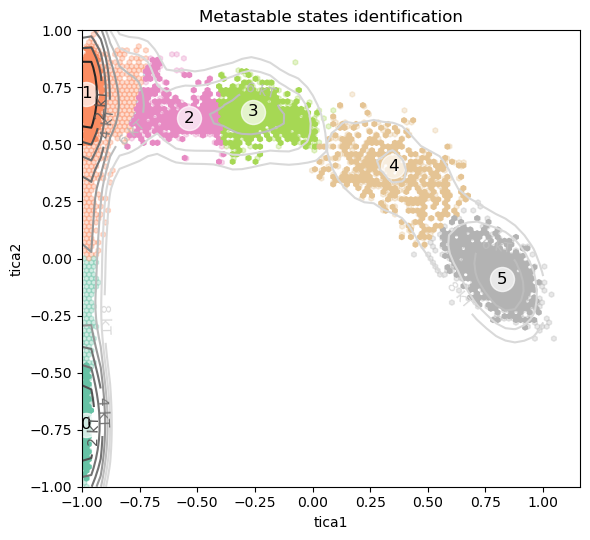

In [6]:
plot_states(data, fes_isolines=True)

In [7]:
for idx in range(data.n_basins):
    l = len(data.basins.loc[ (data.basins['basin'] == idx) & (data.basins['selection'] == True)])
    print(f"{idx} -> {l}")

0 -> 26059
1 -> 70332
2 -> 593
3 -> 857
4 -> 415
5 -> 931


In [11]:
descriptors = data.collect_data()
select_feat = 'HB_DIST'
sample = data.sample(400, regex_filter = select_feat)

In [13]:
sample.configurations.shape

(2400, 10271)

In [48]:
C_range = np.geomspace(2.15443469,  10, 20)
#C_range = np.array([4.64158883])
kwargs = {'LASSO':True, 'max_iter': 100}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)

/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: Convergenc


-- RELEVANT FEATURES --
Over a total of 10271 descriptors LASSO algorithm selected:
State 0:
	 50.8% | HB_DIST ARG39-N -- ALA40-N
	 24.5% | HB_DIST GLY37-N -- CYS38-O
	 11.2% | HB_DIST CYS38-N -- ARG39-N
	 6.1%  | HB_DIST CYS14-N -- CYS38-O
	 4.3%  | HB_DIST GLY12-O -- GLY36-N
	 3.0%  | HB_DIST ILE19-N -- GLY37-O
	 0.0%  | HB_DIST PRO13-N -- GLY36-N
State 1:
	 85.4% | HB_DIST ARG39-O -- ARG42-N
	 8.7%  | HB_DIST LEU6-N -- CYS38-O
	 4.1%  | HB_DIST CYS38-O -- ARG42-N
	 1.2%  | HB_DIST GLU7-N -- CYS38-O
	 0.1%  | HB_DIST ARG39-O -- LYS41-N
	 0.1%  | HB_DIST ARG39-N -- ARG42-N
	 0.1%  | HB_DIST LYS26-N -- LYS41-NZs
	 0.1%  | HB_DIST ALA25-O -- LYS41-NZs
	 0.1%  | HB_DIST ALA25-N -- LYS41-NZs
	 0.0%  | HB_DIST ARG39-N -- ALA40-O
	 0.0%  | HB_DIST LYS26-O -- LYS41-NZs
State 2:
	 62.2% | HB_DIST TYR10-N -- ARG42-O
	 35.6% | HB_DIST LEU6-O -- LYS41-NZs
	 2.2%  | HB_DIST PRO13-N -- ALA27-N
State 3:
	 72.3% | HB_DIST TYR10-O -- ARG39-NH1s
	 10.0% | HB_DIST LEU6-O -- TYR10-N
	 9.8%  | HB_DIST G

<ipython-input-39-89b73671efb1>:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rows = np.int(np.ceil((n_basins + 1)/3))


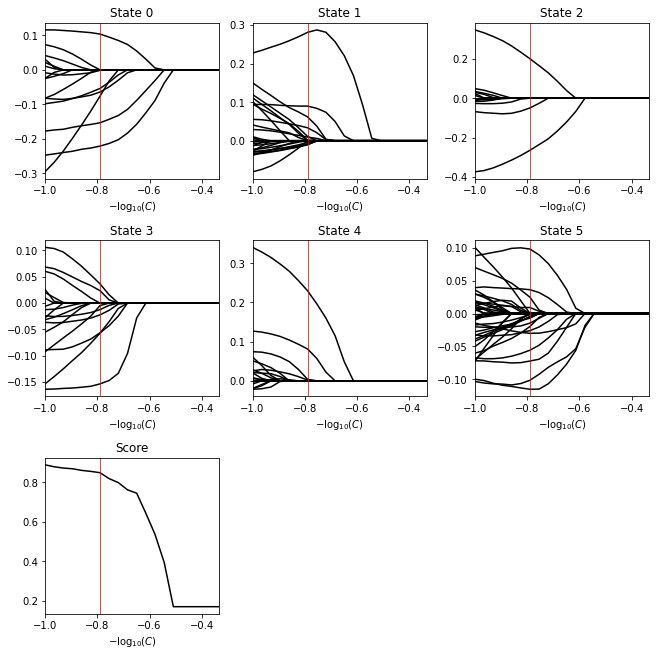

In [50]:
C = np.power(10,0.8)

# PLOT
print('\n-- RELEVANT FEATURES --')
print(f'Over a total of {dset[0][0].shape[0]} descriptors LASSO algorithm selected:')
cvpath.print_relevant_features(C)
plot_cvpath(cvpath,C);

In [ ]:
import pickle

In [39]:
from matplotlib.gridspec import GridSpec
def plot_cvpath(cvpath, C, state_names=None, suptitle=None, normalize_C=True):
    try:
        cvpath._coeffs
        cvpath._C_range
        cvpath._crossval
    except NameError:
        raise ValueError("CV_path not computed.")

    coeffs = cvpath._coeffs
    if normalize_C:
        C_range = cvpath._C_range*cvpath._n_samples
    else:
        C_range = cvpath._C_range
    crossval = cvpath._crossval

    n_basins = coeffs.shape[1]

    C_idx = np.argmin(np.abs(C_range - C))
    if not state_names:
        state_names = [f'State {idx}' for idx in cvpath.classes_labels[C_idx]]
    assert len(state_names) == n_basins

    rows = np.int(np.ceil((n_basins + 1)/3))
    fig = plt.figure(constrained_layout=True, figsize=(9,3*rows))
    gs = GridSpec(rows, 3, figure=fig)

    axes = []
    for basin_idx in range(n_basins):
        axes.append(fig.add_subplot(gs[np.unravel_index(basin_idx, (rows, 3))]))
    axes.append(fig.add_subplot(gs[np.unravel_index(n_basins, (rows, 3))]))
    
    
    if suptitle:
        fig.suptitle(suptitle)
    for idx in range(n_basins):
        ax = axes[idx]
        _cfs = coeffs[:,idx,:]
        killer = np.abs(np.sum(_cfs, axis=0)) >= 1e-8
        ax.plot(np.log10(1/C_range), _cfs[:,killer], 'k-')
        ax.axvline(x = np.log10(1/C_range[C_idx]), color='r', linewidth=0.75)
        ax.set_xlim(np.log10(1/C_range[-1]), np.log10(1/C_range[0]))
        ax.set_xlabel(r"$-\log_{10}(C)$")
        ax.set_title(state_names[idx])
        
    ax = axes[-1]
    ax.plot(np.log10(1/C_range), crossval, 'k-')
    ax.axvline(x = np.log10(1/C_range[C_idx]), color='r', linewidth=0.75)
    ax.set_xlim(np.log10(1/C_range[-1]), np.log10(1/C_range[0]))
    ax.set_xlabel(r"$-\log_{10}(C)$")
    ax.set_title("Score")
    return (fig, axes)

In [51]:
kwargs = {'LASSO':True, 'max_iter': 1000}
prunedcv = cvpath.get_pruned_CVpath(C)
prunedcv.compute(C_range_in, **kwargs);

/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: Convergenc

In [59]:
C = np.power(10,0.9)

# PLOT
#plot_cvpath(prunedcv,C);
print('\n-- RELEVANT FEATURES --')
print(f'Over a total of {prunedcv._dset[0][0].shape[0]} descriptors LASSO algorithm selected:')
prunedcv.print_relevant_features(C)


-- RELEVANT FEATURES --
Over a total of 49 descriptors LASSO algorithm selected:
State 0:
	 48.3% | HB_DIST CYS14-N -- CYS38-O || HB_DIST CYS38-N -- ARG39-N
	 39.1% | HB_DIST GLY37-N -- CYS38-O || HB_DIST GLY12-O -- GLY36-N
	 4.0%  | HB_DIST GLY12-O -- GLY36-N || HB_DIST ARG39-N -- ALA40-N
	 3.0%  | HB_DIST CYS14-N -- CYS38-O || HB_DIST GLY12-O -- GLY36-N
	 2.3%  | HB_DIST CYS38-N -- ARG39-N
	 1.3%  | HB_DIST CYS14-N -- CYS38-O || HB_DIST ARG39-N -- ALA40-N
	 1.2%  | HB_DIST GLY37-N -- CYS38-O || HB_DIST ARG39-N -- ALA40-N
	 0.6%  | HB_DIST GLY12-O -- GLY36-N
	 0.2%  | HB_DIST ARG39-N -- ALA40-N || HB_DIST CYS38-N -- ARG39-N
	 0.0%  | HB_DIST ILE19-N -- GLY37-O
	 0.0%  | HB_DIST ILE19-N -- GLY37-O || HB_DIST ARG39-N -- ALA40-N
State 1:
	 39.3% | HB_DIST ARG39-O -- ARG42-N
	 22.7% | HB_DIST LEU6-N -- CYS38-O || HB_DIST CYS38-O -- ARG42-N
	 16.9% | HB_DIST ARG39-O -- ARG42-N || HB_DIST ARG39-N -- ALA40-O
	 13.4% | HB_DIST LYS26-N -- LYS41-NZs
	 4.2%  | HB_DIST GLU7-N -- CYS38-O || HB_DI